Reference:
https://facebook.github.io/prophet/docs/quick_start.html#python-api


In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [15]:
predictors = pd.read_excel('./predictors_monthly.xlsx')
commodity = pd.read_excel('./Commodities_Monthly.xlsx')
futures = pd.read_excel('./Futures_Monthly.xlsx')

In [16]:
predictors = predictors[46:].reset_index(drop=True)
predictors.set_index('date', inplace=True)
def preprocess(commodity, drop_col):
    commodity = commodity[35:].reset_index(drop=True)
    commodity['date'] = predictors.index
    commodity = commodity.drop(['Year_Month', drop_col], axis=1)
    commodity.set_index('date', inplace=True)
    return commodity
commodity = preprocess(commodity, 'Grains_Spot')
futures = preprocess(futures, 'Grains')

In [17]:
predictors = predictors[predictors.columns[:14]]

In [18]:
predictors['CPI Change'] = predictors['CPURNSA Index'].diff()
predictors = predictors[1:]
commodity = commodity[1:]
futures = futures[1:]
pred_orig = predictors
comm_orig = commodity
fut_orig = futures
# Predict 3 months into the future
predictors = predictors[:-3]
futures = futures[:-3]
commodity = commodity[3:]
# Normalize Predictors
predictors = (predictors-predictors.min())/(predictors.max()-predictors.min())
predictors = predictors.drop(labels='MSCI US Equity', axis=1)

In [19]:
commodity

,Agriculture_Spot,Energy_Spot,Industrial_Metals_Spot,Livestock_Spot,Precious_Metals_Spot
date,,,,,
2005-03-01,149.016582,322.704968,133.276273,140.862305,131.145723
2005-04-01,145.138614,324.381038,129.501729,139.126286,129.327733
2005-05-01,144.952314,298.723548,123.910267,136.862995,127.366286
2005-06-01,152.292250,333.352973,127.075014,127.175827,130.703882
2005-07-01,154.008880,348.656560,126.842355,122.620220,128.129135
...,...,...,...,...,...
2022-04-01,504.394335,567.135295,367.461420,219.437445,562.850785
2022-05-01,508.215676,630.529705,323.461643,209.311657,528.029933
2022-06-01,472.593681,638.126038,304.422452,211.310857,523.682552


Text(0, 0.5, 'Spot')

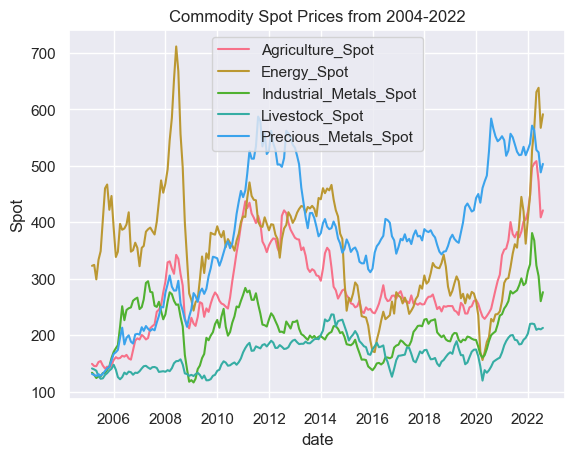

In [20]:
sns.set_theme()
sns.set_palette("husl")
ax = sns.lineplot(commodity, dashes=False)
ax.set_title("Commodity Spot Prices from 2004-2022")
ax.set_ylabel("Spot")

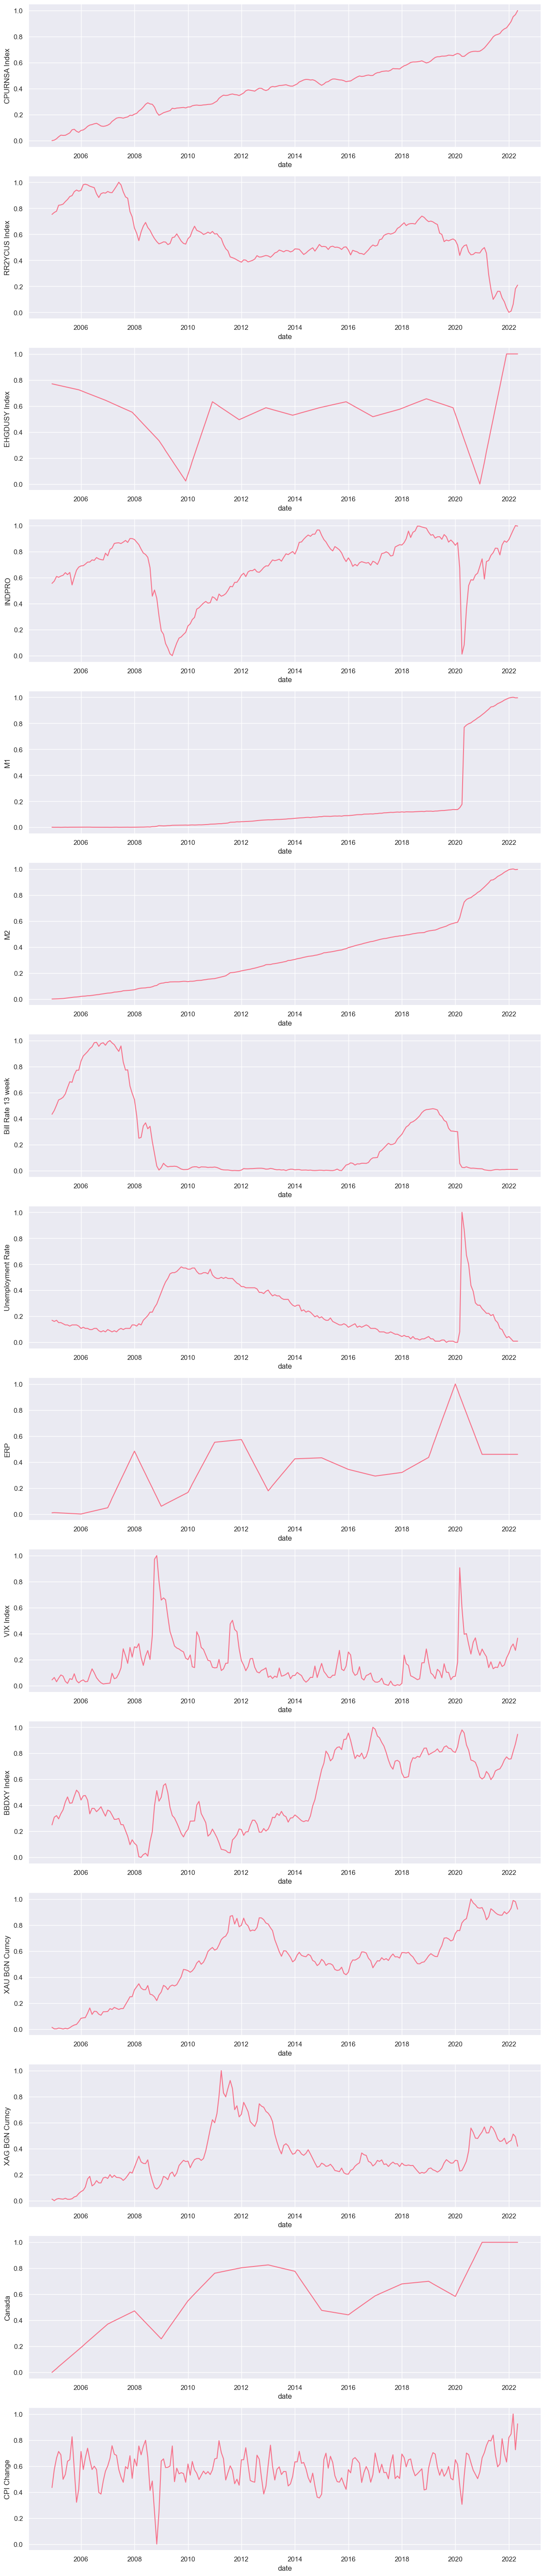

In [103]:
sns.set_theme()
sns.set_palette("husl")
f, axes = plt.subplots(len(predictors.columns), figsize=(15, 75))
for i, col in enumerate(predictors.columns):
    sns.lineplot(predictors[col], dashes=False, ax=axes[i])
# ax.set_title("Predictors from 2004-2022")
# ax.set_ylabel("Normalized Value")

# FBProphet

In [137]:
def TSProphet(com, com_fut, pred_list=['EHGDUSY Index', 'CPI Change', 'RR2YCUS Index']):
    df = pd.DataFrame()
    df['ds'] = commodity.index
    df['y'] = commodity[com].values
    model = Prophet()
    for p in pred_list:
        df[p] = predictors[p].values
        model.add_regressor(p)
    if com_fut:
        df[com_fut] = futures[com_fut].values
        model.add_regressor(com_fut)
    test_pd = 12
    train = df[:-test_pd]
    model.fit(train)
#     model.fit(df)
    

#     cutoffs = pd.to_datetime(['2012-12-01', '2014-12-01', '2016-12-01', '2018-12-01', '2020-12-01', '2022-05-01'])
#     df_cv = cross_validation(model, cutoffs=cutoffs, horizon = '90 days')
#     print(df_cv)
#     df_p = performance_metrics(df_cv)
#     print(df_p)
#     forecast = model.predict(df_cv)
    


    future = model.make_future_dataframe(periods=test_pd, freq='MS')
    for p in pred_list:
        future[p] = df[p].values
    if com_fut:
        future[com_fut] = futures[com_fut].values
    forecast = model.predict(future)
    forecast['actual'] = df['y'].values
    trainMSE = mean_squared_error(forecast['actual'][:-test_pd], forecast['yhat'][:-test_pd], squared=False)
    testMSE = mean_squared_error(forecast['actual'][-test_pd:], forecast['yhat'][-test_pd:], squared=False)
    trainMAE = mean_absolute_error(forecast['actual'][:-test_pd], forecast['yhat'][:-test_pd])
    testMAE = mean_absolute_error(forecast['actual'][-test_pd:], forecast['yhat'][-test_pd:])
    trainR2 = r2_score(forecast['actual'][:-test_pd], forecast['yhat'][:-test_pd])
    testR2 = r2_score(forecast['actual'][-test_pd:], forecast['yhat'][-test_pd:])
    print(f"Train RMSE: {trainMSE}")
    print(f"Test RMSE: {testMSE}")
    print(f"Train MAE: {trainMAE}")
    print(f"Test MAE: {testMAE}")
    print(f"Train R2: {trainR2}")
    print(f"Test R2: {testR2}")
    
    fig = model.plot(forecast)
#     a = add_changepoints_to_plot(fig.gca(), model, forecast)
#     sns.lineplot(x=forecast['ds'], y=forecast['yhat'])
    plt.axvline(pd.Timestamp('2021-08-01'), color='black', ls=':')

    sns.scatterplot(x=forecast['ds'], y=forecast['actual'], color='black', s=15)
    model.plot_components(forecast)

    return forecast
    

In [45]:
def rollingTSProphet(com, com_fut, pred_list=['EHGDUSY Index', 'CPI Change', 'RR2YCUS Index']):
    df = pd.DataFrame()
    df['ds'] = commodity.index
    df['y'] = commodity[com].values    
    for p in pred_list:
        df[p] = predictors[p].values
    if com_fut:
        df[com_fut] = futures[com_fut].values
    test_pd = 24
    n = len(df)
    train_preds = pd.DataFrame()
    test_preds = []
    for test_i in range(test_pd):
        
        # Instantiate Model
        model = Prophet()
        for p in pred_list:
            model.add_regressor(p)
        if com_fut:
            model.add_regressor(com_fut)
            
        # Train on new data
        train = df[test_i:n-test_pd+test_i]
        model.fit(train)
        
        
        # Make 1 prediction        
        future = model.make_future_dataframe(periods=1, freq='MS')
        for p in pred_list:
            future[p] = df[test_i:n-test_pd+test_i+1][p].values
        if com_fut:
            future[com_fut] = futures[test_i:n-test_pd+test_i+1][com_fut].values
        forecast = model.predict(future)
        
        # Save predictions
        if test_i == 0:
            train_preds = forecast[:-1][['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
        test_preds.append({
            'ds':forecast.iloc[-1]['ds'], 'yhat_lower':forecast.iloc[-1]['yhat_lower'], 
            'yhat_upper': forecast.iloc[-1]['yhat_upper'], 'yhat':forecast.iloc[-1]['yhat']
        })
    test_preds = pd.DataFrame(test_preds)
    forecast = train_preds.append(test_preds, ignore_index = True)          
        
    forecast['actual'] = df['y'].values
    trainMSE = mean_squared_error(forecast['actual'][:-test_pd], forecast['yhat'][:-test_pd], squared=False)
    testMSE = mean_squared_error(forecast['actual'][-test_pd:], forecast['yhat'][-test_pd:], squared=False)
    trainMAE = mean_absolute_error(forecast['actual'][:-test_pd], forecast['yhat'][:-test_pd])
    testMAE = mean_absolute_error(forecast['actual'][-test_pd:], forecast['yhat'][-test_pd:])
    trainR2 = r2_score(forecast['actual'][:-test_pd], forecast['yhat'][:-test_pd])
    testR2 = r2_score(forecast['actual'][-test_pd:], forecast['yhat'][-test_pd:])
    print(f"Train RMSE: {trainMSE}")
    print(f"Test RMSE: {testMSE}")
    print(f"Train MAE: {trainMAE}")
    print(f"Test MAE: {testMAE}")
    print(f"Train R2: {trainR2}")
    print(f"Test R2: {testR2}")

    fig = model.plot(forecast)
    plt.axvline(pd.Timestamp('2020-08-01'), color='black', ls=':')
    sns.scatterplot(x=forecast['ds'], y=forecast['actual'], color='black', s=15)
    return forecast
   

In [164]:
results = pd.DataFrame()

In [166]:
results

,date,Agriculture_Prediction,Agriculture_Actual
0,2005-03-01,138.179239,149.016582
1,2005-04-01,134.567381,145.138614
2,2005-05-01,136.637077,144.952314
3,2005-06-01,140.766468,152.292250
4,2005-07-01,145.794376,154.008880
...,...,...,...
205,2022-04-01,446.051191,504.394335
206,2022-05-01,474.272814,508.215676
207,2022-06-01,499.228710,472.593681
208,2022-07-01,492.965580,408.583170


21:38:30 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing
21:38:31 - cmdstanpy - INFO - Chain [1] start processing
21:38:31 - cmdstanpy - INFO - Chain [1] done processing
21:38:32 - cmdstanpy - INFO - Chain [1] start processing
21:38:32 - cmdstanpy - INFO - Chain [1] done processing
21:38:33 - cmdstanpy - INFO - Chain [1] start processing
21:38:34 - cmdstanpy - INFO - Chain [1] done processing
21:38:35 - cmdstanpy - INFO - Chain [1] start processing
21:38:35 - cmdstanpy - INFO - Chain [1] done processing
21:38:36 - cmdstanpy - INFO - Chain [1] start processing
21:38:36 - cmdstanpy - INFO - Chain [1] done processing
21:38:37 - cmdstanpy - INFO - Chain [1] start processing
21:38:38 - cmdstanpy - INFO - Chain [1] done processing
21:38:39 - cmdstanpy - INFO - Chain [1] start processing
21:38:39 - cmdstanpy - INFO - Chain [1] done processing
21:38:40 - cmdstanpy - INFO - Chain [1] start processing
21:38:40 - cmdstanpy - INFO - Chain [1]

Train RMSE: 35.54981072130327
Test RMSE: 41.55624708235405
Train MAE: 26.02167160757637
Test MAE: 36.129512614040074
Train R2: 0.7339104501223135
Test R2: 0.5912286678523276


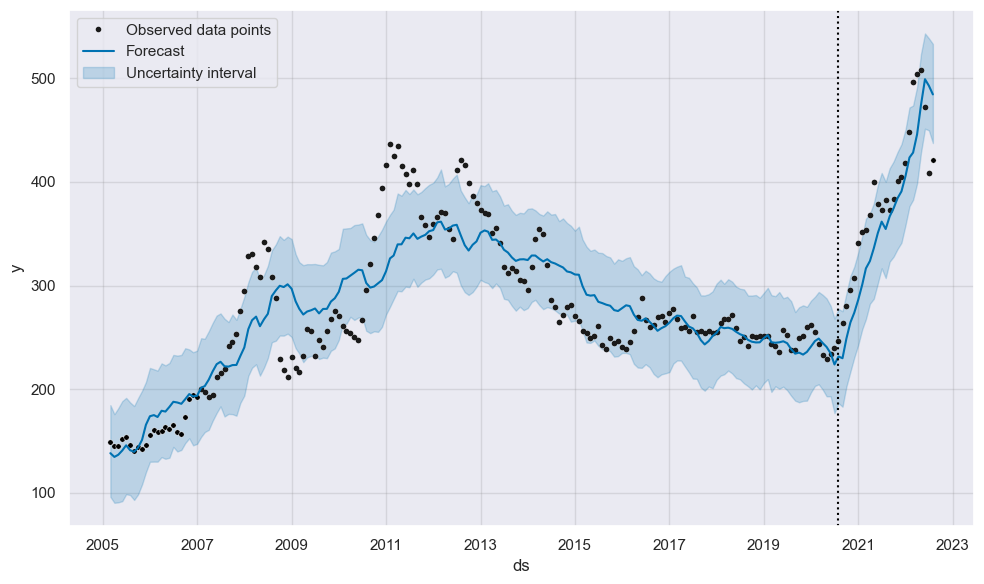

In [167]:
forecast = rollingTSProphet('Agriculture_Spot', 'Agriculture', ['CPURNSA Index', 'M1', 'RR2YCUS Index'])
results[["date", "Agriculture_Prediction", "Agriculture_Actual"]] = forecast[['ds', 'yhat', 'actual']]

21:39:00 - cmdstanpy - INFO - Chain [1] start processing
21:39:00 - cmdstanpy - INFO - Chain [1] done processing
21:39:02 - cmdstanpy - INFO - Chain [1] start processing
21:39:02 - cmdstanpy - INFO - Chain [1] done processing
21:39:03 - cmdstanpy - INFO - Chain [1] start processing
21:39:03 - cmdstanpy - INFO - Chain [1] done processing
21:39:04 - cmdstanpy - INFO - Chain [1] start processing
21:39:04 - cmdstanpy - INFO - Chain [1] done processing
21:39:05 - cmdstanpy - INFO - Chain [1] start processing
21:39:05 - cmdstanpy - INFO - Chain [1] done processing
21:39:07 - cmdstanpy - INFO - Chain [1] start processing
21:39:07 - cmdstanpy - INFO - Chain [1] done processing
21:39:08 - cmdstanpy - INFO - Chain [1] start processing
21:39:08 - cmdstanpy - INFO - Chain [1] done processing
21:39:09 - cmdstanpy - INFO - Chain [1] start processing
21:39:09 - cmdstanpy - INFO - Chain [1] done processing
21:39:10 - cmdstanpy - INFO - Chain [1] start processing
21:39:10 - cmdstanpy - INFO - Chain [1]

Train RMSE: 52.761269074969576
Test RMSE: 49.60294063435838
Train MAE: 41.107220733905734
Test MAE: 38.32694013747379
Train R2: 0.6817480707304289
Test R2: 0.8513128633063972


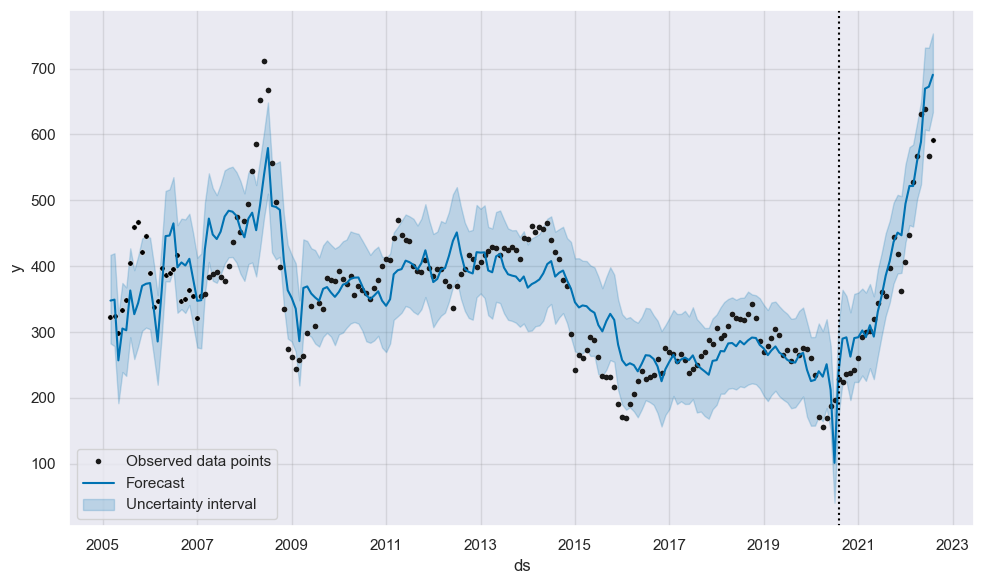

In [168]:
forecast = rollingTSProphet('Energy_Spot', 'Energy', pred_list=['CPURNSA Index', 'RR2YCUS Index', 'INDPRO', 'M1'])
results[["Energy_Prediction", "Energy_Actual"]] = forecast[['yhat', 'actual']]

21:39:31 - cmdstanpy - INFO - Chain [1] start processing
21:39:31 - cmdstanpy - INFO - Chain [1] done processing
21:39:32 - cmdstanpy - INFO - Chain [1] start processing
21:39:32 - cmdstanpy - INFO - Chain [1] done processing
21:39:33 - cmdstanpy - INFO - Chain [1] start processing
21:39:34 - cmdstanpy - INFO - Chain [1] done processing
21:39:35 - cmdstanpy - INFO - Chain [1] start processing
21:39:35 - cmdstanpy - INFO - Chain [1] done processing
21:39:36 - cmdstanpy - INFO - Chain [1] start processing
21:39:36 - cmdstanpy - INFO - Chain [1] done processing
21:39:37 - cmdstanpy - INFO - Chain [1] start processing
21:39:37 - cmdstanpy - INFO - Chain [1] done processing
21:39:38 - cmdstanpy - INFO - Chain [1] start processing
21:39:38 - cmdstanpy - INFO - Chain [1] done processing
21:39:39 - cmdstanpy - INFO - Chain [1] start processing
21:39:39 - cmdstanpy - INFO - Chain [1] done processing
21:39:40 - cmdstanpy - INFO - Chain [1] start processing
21:39:40 - cmdstanpy - INFO - Chain [1]

Train RMSE: 29.891130781454372
Test RMSE: 29.45612363011733
Train MAE: 23.163602529846152
Test MAE: 21.589280959628272
Train R2: 0.446351294220784
Test R2: 0.5449126779356603


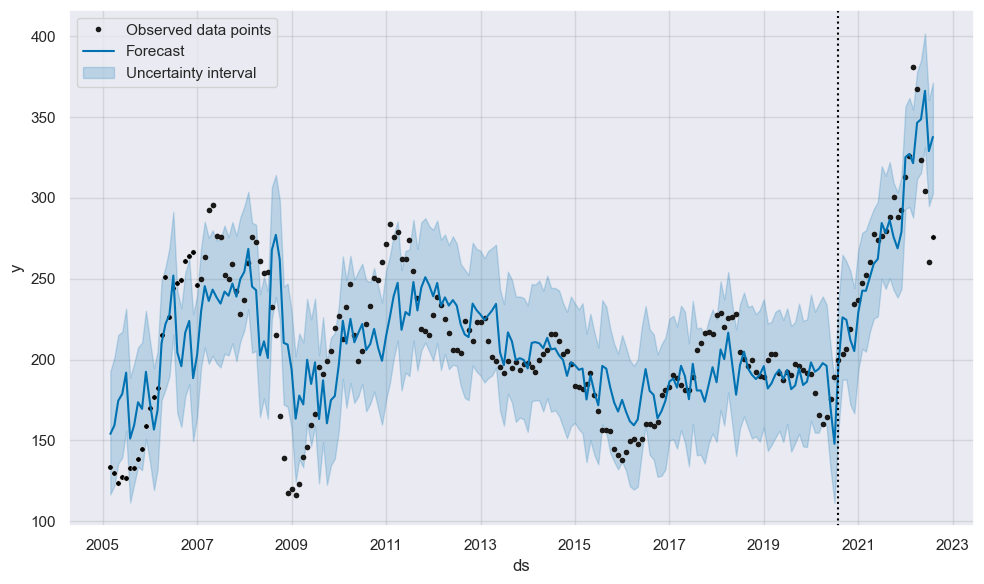

In [169]:
forecast = rollingTSProphet('Industrial_Metals_Spot', 'Industrial_Metals', ['EHGDUSY Index', 'CPI Change', 'INDPRO',  'M1', 'XAU BGN Curncy'])
results[["Industrial_Metals_Prediction", "Industrial_Metals_Actual"]] = forecast[['yhat', 'actual']]

21:40:02 - cmdstanpy - INFO - Chain [1] start processing
21:40:03 - cmdstanpy - INFO - Chain [1] done processing
21:40:04 - cmdstanpy - INFO - Chain [1] start processing
21:40:04 - cmdstanpy - INFO - Chain [1] done processing
21:40:05 - cmdstanpy - INFO - Chain [1] start processing
21:40:05 - cmdstanpy - INFO - Chain [1] done processing
21:40:06 - cmdstanpy - INFO - Chain [1] start processing
21:40:07 - cmdstanpy - INFO - Chain [1] done processing
21:40:08 - cmdstanpy - INFO - Chain [1] start processing
21:40:08 - cmdstanpy - INFO - Chain [1] done processing
21:40:09 - cmdstanpy - INFO - Chain [1] start processing
21:40:09 - cmdstanpy - INFO - Chain [1] done processing
21:40:10 - cmdstanpy - INFO - Chain [1] start processing
21:40:11 - cmdstanpy - INFO - Chain [1] done processing
21:40:12 - cmdstanpy - INFO - Chain [1] start processing
21:40:12 - cmdstanpy - INFO - Chain [1] done processing
21:40:13 - cmdstanpy - INFO - Chain [1] start processing
21:40:13 - cmdstanpy - INFO - Chain [1]

Train RMSE: 24.41612931052699
Test RMSE: 27.99783154513883
Train MAE: 18.922515412329588
Test MAE: 21.528996961258542
Train R2: 0.9515124517073518
Test R2: -1.0222793323919763


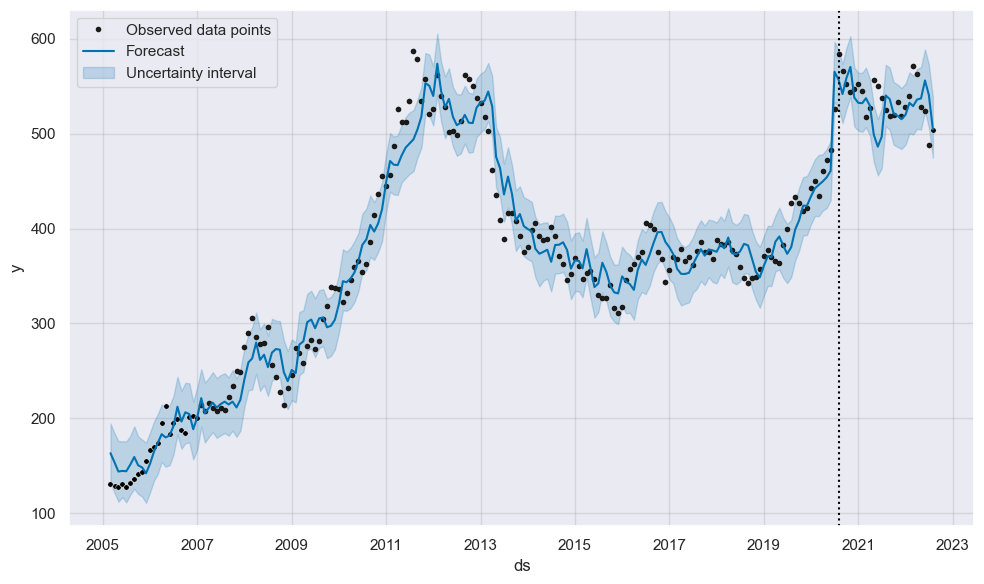

In [170]:
forecast = rollingTSProphet('Precious_Metals_Spot', 'Precious_Metals', ['EHGDUSY Index', 'CPURNSA Index', 'XAU BGN Curncy', 'Unemployment Rate'])
results[["Precious_Metals_Prediction", "Precious_Metals_Actual"]] = forecast[['yhat', 'actual']]

21:40:37 - cmdstanpy - INFO - Chain [1] start processing
21:40:37 - cmdstanpy - INFO - Chain [1] done processing
21:40:38 - cmdstanpy - INFO - Chain [1] start processing
21:40:38 - cmdstanpy - INFO - Chain [1] done processing
21:40:39 - cmdstanpy - INFO - Chain [1] start processing
21:40:39 - cmdstanpy - INFO - Chain [1] done processing
21:40:40 - cmdstanpy - INFO - Chain [1] start processing
21:40:40 - cmdstanpy - INFO - Chain [1] done processing
21:40:41 - cmdstanpy - INFO - Chain [1] start processing
21:40:42 - cmdstanpy - INFO - Chain [1] done processing
21:40:43 - cmdstanpy - INFO - Chain [1] start processing
21:40:43 - cmdstanpy - INFO - Chain [1] done processing
21:40:44 - cmdstanpy - INFO - Chain [1] start processing
21:40:45 - cmdstanpy - INFO - Chain [1] done processing
21:40:46 - cmdstanpy - INFO - Chain [1] start processing
21:40:46 - cmdstanpy - INFO - Chain [1] done processing
21:40:47 - cmdstanpy - INFO - Chain [1] start processing
21:40:47 - cmdstanpy - INFO - Chain [1]

Train RMSE: 11.913739393702352
Test RMSE: 11.236089988715726
Train MAE: 9.174783448612379
Test MAE: 8.801614419231193
Train R2: 0.8046157904986662
Test R2: 0.692194837728864


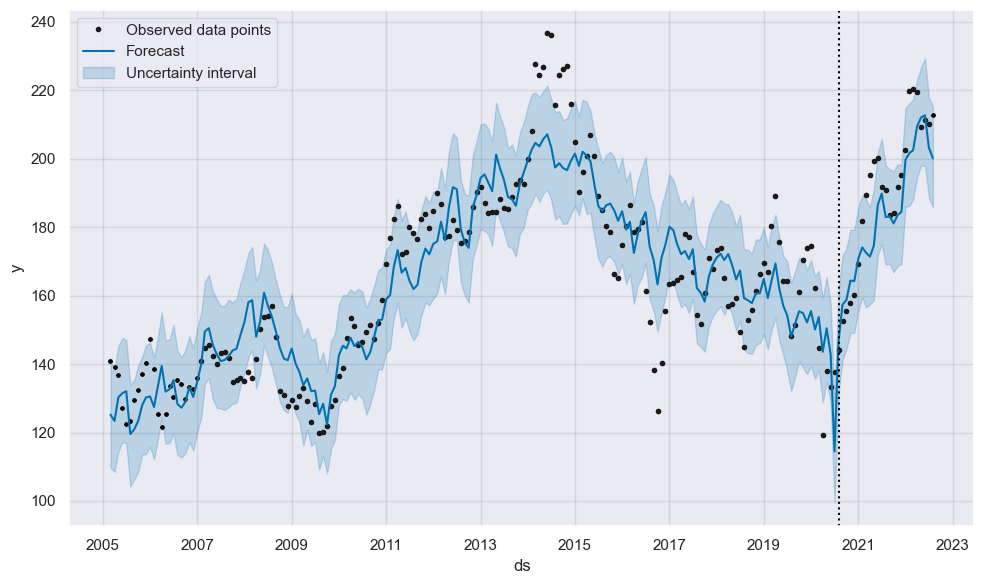

In [171]:
forecast = rollingTSProphet('Livestock_Spot', 'Livestock', ['RR2YCUS Index', 'CPI Change',  'INDPRO', 'M1'])
results[["Livestock_Prediction", "Livestock_Actual"]] = forecast[['yhat', 'actual']]

In [173]:
results.to_csv("../Processed data files/FBProphet_forecasts.csv")

#### How much into the future do we want the predictions? Better predictions for 1 or 2 months into the future
#### In this case should we only look at train accuracy?
#### We can report confidence intervals?

# Linear

In [73]:
import statsmodels.api as sm
import numpy as np
from datetime import datetime

In [75]:
def linear(com, fut, pred):
    x = pred.copy(deep=True)
    x['futures'] = fut
    x = sm.add_constant(x)
    pd = 12
    trainX = x[:-pd]
    trainY = com[:-pd]
    testX = x[-pd:]
    testY = com[-pd:]
    model = sm.OLS(list(trainY),trainX)
    results = model.fit()
    print(results.summary())
    pred = results.predict(testX)
    print(mean_squared_error(testY, pred, squared=False))
    print(mean_absolute_error(testY, pred)) 
    print(r2_score(testY, pred))
    pred = results.predict(x)
    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.lineplot(x=com.index, y=pred)
    ax.set(ylabel=com.name)
    plt.axvline(datetime(2021,8,1), color='black', ls=':')
    sns.scatterplot(x=com.index, y=list(com), color='black', s=15)

In [99]:
def rollingLinear(com, fut, pred):
    x = pred.copy(deep=True)
    x['futures'] = fut
    x = sm.add_constant(x)
    pd = 24
    n = len(x)
    testY = com[-pd:]
    pred = []
    for pd_i in range(pd):
        trainX = x[pd_i:n-pd+pd_i]
        trainY = com[pd_i:n-pd+pd_i]
        testX = x[-pd+pd_i:n-pd+pd_i+1]
        model = sm.OLS(list(trainY),trainX)
        results = model.fit()
        pred_i = results.predict(testX)
        pred.append(pred_i.values.tolist()[0])
        if pd_i == 0:
            print(results.summary()) 
    print(f"MAE: {mean_absolute_error(testY, pred)}")
    print(f"RMSE: {mean_squared_error(testY, pred, squared=False)}") 
    print(f"R2: {r2_score(testY, pred)}")
    pred = results.predict(x)
    fig, ax = plt.subplots(figsize=(12,8))
    ax = sns.lineplot(x=com.index, y=pred, lw=2)
    ax.set(ylabel=com.name)  
    sns.scatterplot(x=com.index, y=list(com), color='black', s=20)
    plt.axvline(datetime(2021,8,1), color='black', ls=':')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     60.31
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           6.93e-60
Time:                        20:15:13   Log-Likelihood:                -879.75
No. Observations:                 186   AIC:                             1792.
Df Residuals:                     170   BIC:                             1843.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               148.2346     49.22

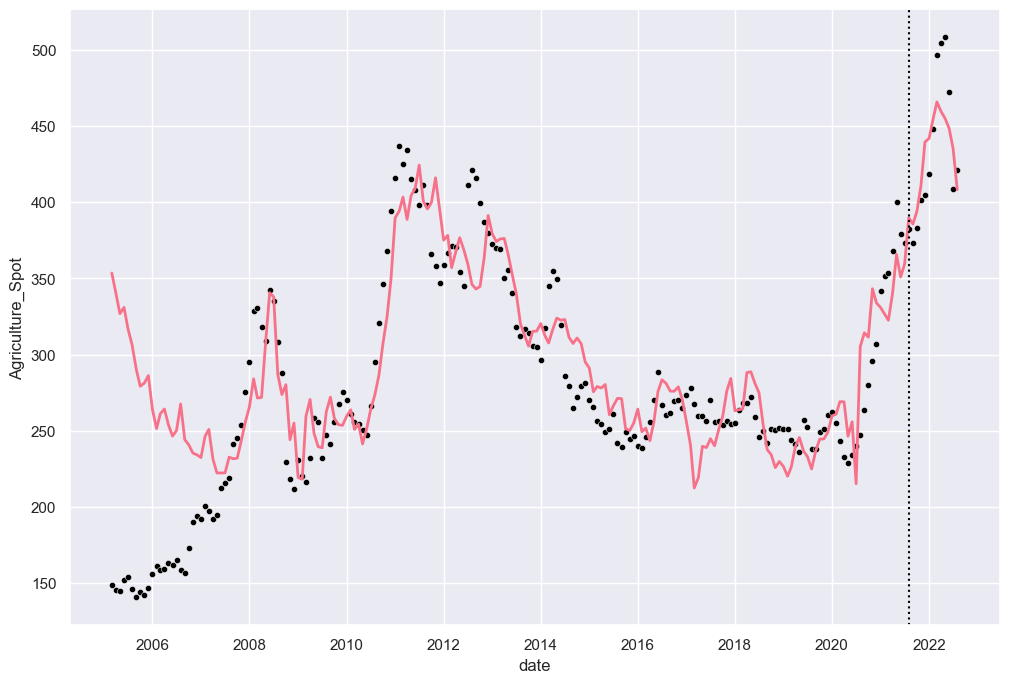

In [100]:
rollingLinear(commodity['Agriculture_Spot'], futures['Agriculture'], predictors)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     38.55
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           9.22e-47
Time:                        20:07:57   Log-Likelihood:                -970.21
No. Observations:                 186   AIC:                             1972.
Df Residuals:                     170   BIC:                             2024.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               431.6042     83.34

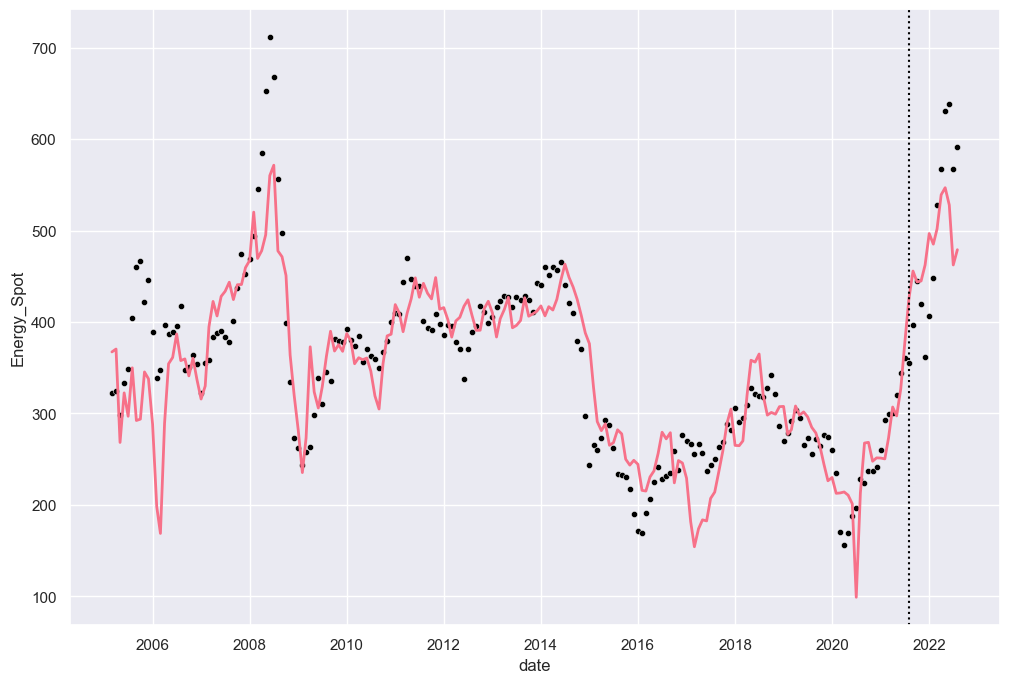

In [84]:
rollingLinear(commodity['Energy_Spot'], futures['Energy'], predictors)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     27.28
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           1.49e-37
Time:                        20:08:05   Log-Likelihood:                -836.86
No. Observations:                 186   AIC:                             1706.
Df Residuals:                     170   BIC:                             1757.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                22.5530     34.44

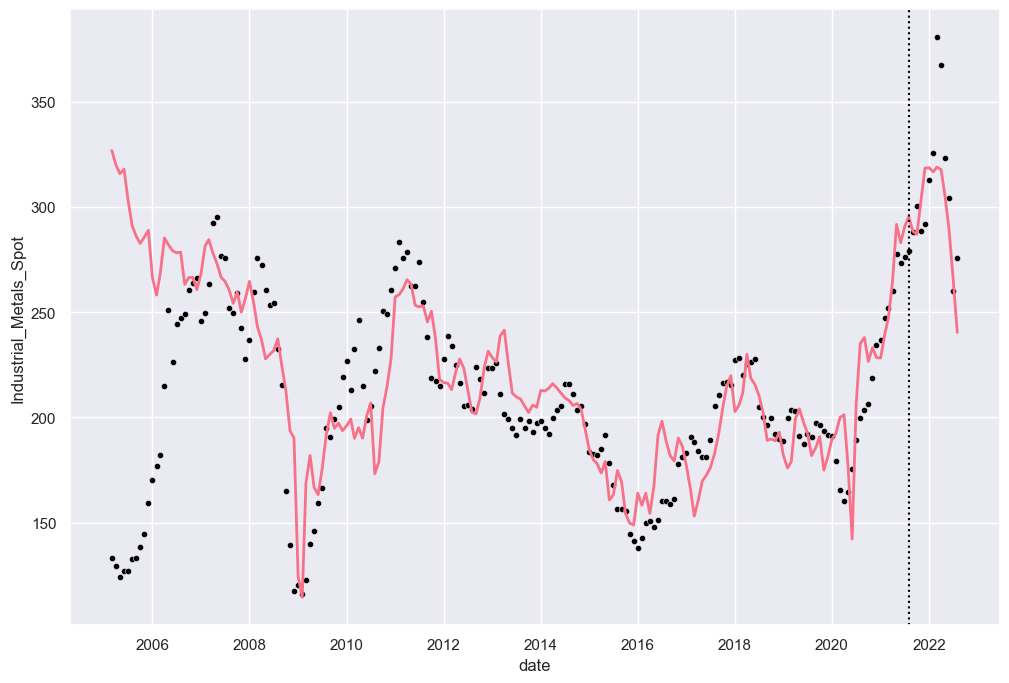

In [85]:
rollingLinear(commodity['Industrial_Metals_Spot'], futures['Industrial_Metals'], predictors)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     254.9
Date:                Sun, 13 Nov 2022   Prob (F-statistic):          5.44e-108
Time:                        20:08:12   Log-Likelihood:                -846.12
No. Observations:                 186   AIC:                             1724.
Df Residuals:                     170   BIC:                             1776.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                89.0460     36.67

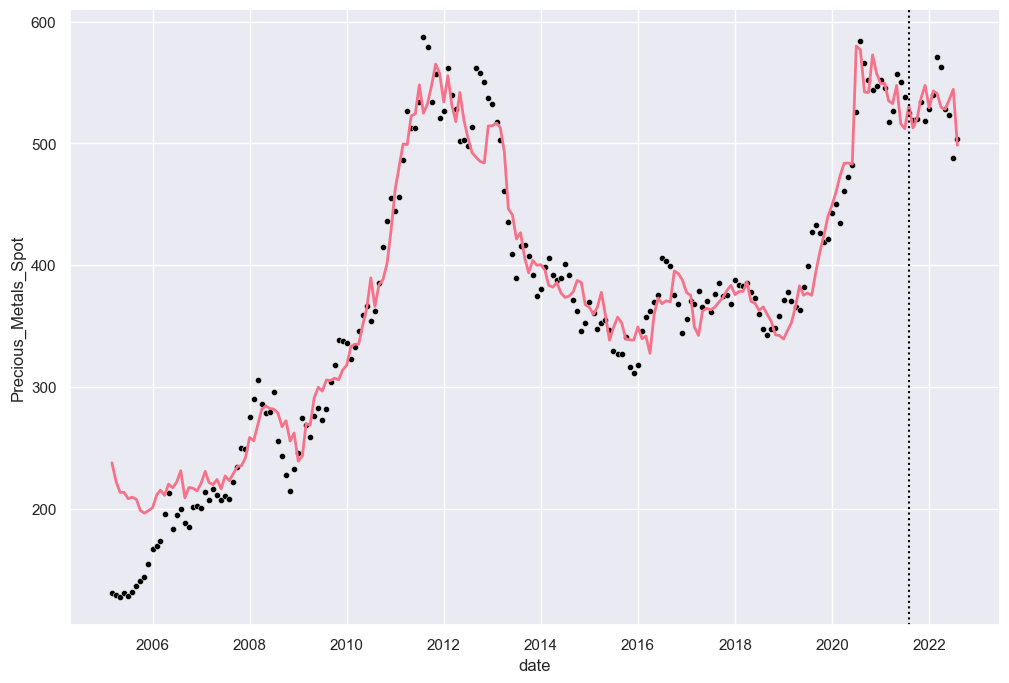

In [86]:
rollingLinear(commodity['Precious_Metals_Spot'], futures['Precious_Metals'], predictors)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     42.30
Date:                Sun, 13 Nov 2022   Prob (F-statistic):           2.21e-49
Time:                        20:08:21   Log-Likelihood:                -732.05
No. Observations:                 186   AIC:                             1496.
Df Residuals:                     170   BIC:                             1548.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                86.7158     28.00

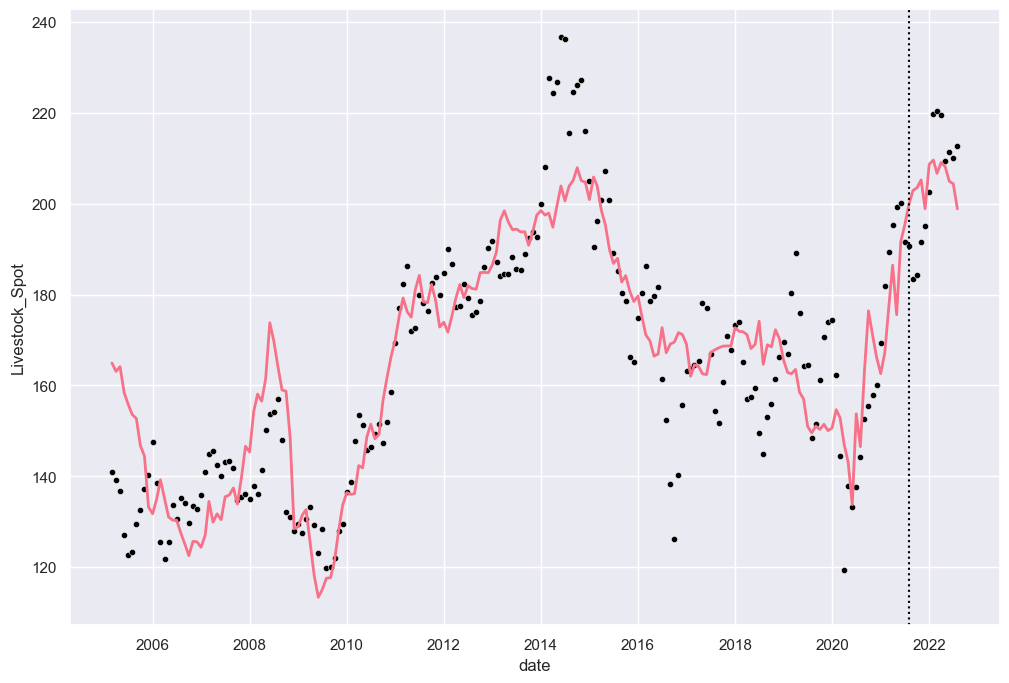

In [87]:
rollingLinear(commodity['Livestock_Spot'], futures['Livestock'], predictors)

# Ignore this code -----

In [168]:
from sklearn.linear_model import LinearRegression
def helper_results(com, com_fut, data):
    model = LinearRegression(fit_intercept=True)
    pd = 12
    x = data.copy(deep=True)
    x['future'] = futures[com_fut]
    trainX = x[:-pd]    
    trainY = commodity[:-pd]
    testX = x[-pd:]
    print(trainY[com].mean())
    testY = commodity[-pd:]
    model = model.fit(trainX, trainY[com])
    print(model.feature_names_in_)
    print(model.coef_)
    print(f"Train Score: {model.score(trainX, trainY[com])}")
    pred = model.predict(testX)
    r2 = r2_score(testY[com], pred)
    mae = mean_absolute_error(testY[com], pred)
    rmse = mean_squared_error(testY[com], pred, squared=False)
    print(f"Test R2 Score: {r2}")
    print(f"Test RMSE Score: {rmse}")
    print(f"Test MAE Score: {mae}")


In [71]:
helper_results('Agriculture_Spot','Agriculture', predictors)

275.4247342521222
['CPURNSA Index' 'RR2YCUS Index' 'EHGDUSY Index' 'INDPRO' 'M1' 'M2'
 'Bill Rate 13 week' 'Unemployment Rate' 'ERP' 'VIX Index' 'BBDXY Index'
 'XAU BGN Curncy' 'XAG BGN Curncy' 'CPI Change' 'future']
[ 78.6454451   64.6548447  -14.45025045  61.33968362  43.47112245
 -96.09952234 -89.72027431  20.2471003   22.24397601  28.36487976
 -64.12239759   1.61439977 224.72659526   8.37972816  -0.72932072]
Train Score: 0.8232439061155529
Test R2 Score: -9.05652316595495
Test RMSE Score: 145.5116398833967
Test MAE Score: 134.03046143387317


In [322]:
helper_results('Energy_Spot','Energy', predictors)

Train Score: 0.7776520402918283
Test R2 Score: -3.768843410210005
Test RMSE Score: 204.2693559717384
Test MAE Score: 172.62072078370798


In [323]:
helper_results('Industrial_Metals_Spot','Industrial_Metals', predictors)

Train Score: 0.6863909276819811
Test R2 Score: -32.76137245834344
Test RMSE Score: 196.7919119481185
Test MAE Score: 187.75075491392246


In [324]:
helper_results('Precious_Metals_Spot','Precious_Metals', predictors)

Train Score: 0.9612965162503248
Test R2 Score: -1.1533320311291226
Test RMSE Score: 31.935930370276118
Test MAE Score: 23.01574328866751


In [325]:
helper_results('Livestock_Spot','Livestock', predictors)

Train Score: 0.7756821417470208
Test R2 Score: -0.7452656612880311
Test RMSE Score: 16.97002079879767
Test MAE Score: 15.642907655456952


In [161]:
futures['Agriculture']

date
2004-12-01    62.216000
2005-01-01    59.338865
2005-02-01    58.999314
2005-03-01    56.876845
2005-04-01    57.828467
                ...    
2022-01-01    62.562220
2022-02-01    67.120968
2022-03-01    74.479178
2022-04-01    75.944885
2022-05-01    76.688276
Name: Agriculture, Length: 210, dtype: float64